# Test Mining for Non-DSC Segment

### Data Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jzhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Import Data File
raw=pd.read_csv("0712 nonDSC SEG - Copy.csv")

In [4]:
# Examning NAs
print raw.isnull().sum(), 
'shape of raw', raw.shape

Unnamed: 0                  0
X                           0
loan_id                     0
charge_off_type             0
charge_off_d                0
product                     0
charge_off_gross_bal        0
charge_off_month            0
grade                    2128
term                     2128
three_month_repayment    2085
six_month_repayment      4986
nine_month_repayment     7695
comments                   14
numb_of_comments           14
dtype: int64

('shape of raw', (30646, 15))

In [5]:
 # Remove rows with NA in comments and prin_paid
modifiedRaw = raw.dropna(subset = ['comments', 'six_month_repayment'])
print raw.shape[0]-modifiedRaw.shape[0], 'rows were dropped.'

4999 rows were dropped.


In [6]:
modifiedRaw.isnull().sum()

Unnamed: 0                  0
X                           0
loan_id                     0
charge_off_type             0
charge_off_d                0
product                     0
charge_off_gross_bal        0
charge_off_month            0
grade                    2125
term                     2125
three_month_repayment       0
six_month_repayment         0
nine_month_repayment     2707
comments                    0
numb_of_comments            0
dtype: int64

In [89]:
modifiedRaw.groupby('charge_off_month').loan_id.count()
modifiedRaw = modifiedRaw[modifiedRaw['charge_off_month']>2016-10]

In [59]:
# Add dollar percent recovered in three month, six month, nine month as attributes
modifiedRaw['percent_recovered_three_month'] = modifiedRaw['three_month_repayment']/modifiedRaw['charge_off_gross_bal']
modifiedRaw['percent_recovered_six_month'] = modifiedRaw['six_month_repayment']/modifiedRaw['charge_off_gross_bal']
modifiedRaw['percent_recovered_nine_month'] = modifiedRaw['nine_month_repayment']/modifiedRaw['charge_off_gross_bal']

In [60]:
# Selecting on prime and near prime
##prime = modifiedRaw['product'] =='Prime'
##nearprime = modifiedRaw['product'] == 'Near Prime'
##modifiedRaw = modifiedRaw[prime | nearprime]

In [61]:
# Select only observations with six_month_repayment non-negative
modifiedRaw = modifiedRaw[modifiedRaw['six_month_repayment']>-0.0001]
modifiedRaw.shape

(25603, 18)

### Descriptive Analysis

This project is based on six month repayment of charge-off loans, so the following descriptive analysis are all in terms of six month after loans charge off date.

In [62]:
# number of loan_id having 0 paid back amount
count_zero_repay = modifiedRaw.groupby('six_month_repayment').loan_id.count()[0]

In [11]:
float((count_zero_repay +0.00)/modifiedRaw.shape[0])
print 'The six-month unit bad rate is', float((count_zero_repay +0.00)/modifiedRaw.shape[0])
print 'The six-month unit recovery rate is', 1 - float((count_zero_repay +0.00)/modifiedRaw.shape[0])

The six-month unit bad rate is 0.871538491583
The six-month unit recovery rate is 0.128461508417


In [12]:
a = sum(modifiedRaw['six_month_repayment'])/sum(modifiedRaw['charge_off_gross_bal']) # overall recovered dollar percentage
print'Overall six-month recovered dollar percentage is', a

Overall six-month recovered dollar percentage is 0.0247238649195


In [13]:
#raw.charge_off_gross_bal.max()

In [14]:
#import matplotlib.pyplot as plt
#plt.hist(modifiedRaw['six_month_repayment'], color = 'blue', edgecolor = 'black', bins = int(11000/1), density = True)
#plt.xlim([0, 15000])
#plt.ylim([0, 0.001])

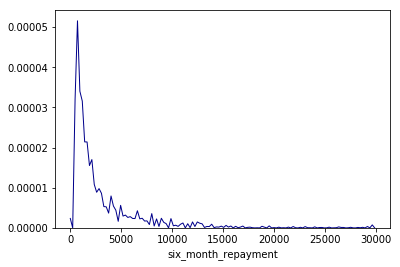

In [16]:
import seaborn as sns
# Density Plot of dollars repaid
sns.distplot(modifiedRaw['six_month_repayment'], hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

### Text Processing

In [63]:
# Process text
nltk.download('words')
from nltk.corpus import words
words = set(nltk.corpus.words.words())
def get_stemmed_text(text):
    text = text.lower() # lowercase
    text = re.sub("<!--?.*?-->","",text) # removetags
    text = re.sub("(\\d|\\W)+"," ",text) # remove special characters and digits
    text = text.replace('[^\w\s]','') # remove punctuation
    text = re.sub(" \d+", " ", text)
    stemmer = PorterStemmer() # stemming
    return stemmer.stem(text)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jzhu\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [64]:
modifiedRaw['comments'] = modifiedRaw['comments'].apply(lambda x:get_stemmed_text(x))

In [65]:
# See one example
modifiedRaw['comments'].iloc[100]

'col old collector moving cell phone from day phone scrub complete request name n'

In [66]:
# Remove words with no meaning
nltk.download('words')
from nltk.corpus import words
from nltk.tokenize import sent_tokenize, word_tokenize 
words = set(nltk.corpus.words.words())
def remove_nonsense_word(text):
    return " ".join(w for w in word_tokenize(text) if w in words)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jzhu\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [67]:
modifiedRaw['comments'] = modifiedRaw['comments'].apply(lambda x:remove_nonsense_word(x))

In [20]:
# See the example
modifiedRaw['comments'].iloc[100]

'col old collector moving cell phone from day phone scrub complete request name n'

In [423]:
#modifiedRaw.groupby('pco_prin_paid').loan_id.count()

### Train and Test Split

In [21]:
# add target
Y = 1.0 * (modifiedRaw['percent_recovered_six_month']>0)

In [22]:
X_train1, X_test1, y_train, y_test = train_test_split(modifiedRaw, Y, stratify = Y, test_size = 0.33, random_state = 42)

In [23]:
X_train = X_train1['comments']
X_test = X_test1['comments']

### Text Vecterization 

In [91]:
stop_words = set(stopwords.words('english'))
# hand pick nonsense word from the keywords used in model and run the model again
stop_words.update(['sip','th','ref', 'mo','mi','doc','da','id','ne','sh','pst','oh','nu','ad','al','alt','fa','pa','pu','us','ga','se','ca','ret'])

In [92]:
# remove words occuring in more than 90% of the documents
# remove words occuring less than 20 times
# remove stopwords
cv = CountVectorizer(max_df = 0.90, min_df = 20, stop_words = stop_words)
X_train_counts = cv.fit_transform(X_train)

In [93]:
#cv.vocabulary_.get(u'portal'),cv.vocabulary_.get(u'mp'),cv.vocabulary_.get(u'looking')
#print(cv.get_feature_names())
#list(cv.vocabulary_.keys())[11]

In [94]:
tfidf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)

In [95]:
X_test_counts = cv.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [31]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor # check for multicollinearity
#vif = [variance_inflation_factor(ddd.values, i) for i in range(ddd.shape[1])]

In [32]:
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS # stepwise selection

### Building Logistic Regression

In [33]:
# Baseline model
clf = LogisticRegression().fit(X_train_tfidf, y_train) # Lasso 

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
# number of keywords/attributes
np.count_nonzero(clf.coef_)

394

### Hyperparameter Tuning

In [67]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

In [68]:
np.logspace(-10,10,15)

array([1.00000000e-10, 2.68269580e-09, 7.19685673e-08, 1.93069773e-06,
       5.17947468e-05, 1.38949549e-03, 3.72759372e-02, 1.00000000e+00,
       2.68269580e+01, 7.19685673e+02, 1.93069773e+04, 5.17947468e+05,
       1.38949549e+07, 3.72759372e+08, 1.00000000e+10])

In [69]:
lr_params = {'penalty': ['l1'],
          'solver':['liblinear'],
          'C': np.logspace(-10,10,21),
            'fit_intercept':[True, False]}

In [70]:
lr_grid = GridSearchCV(clf, param_grid=lr_params, cv=3, n_jobs=-1, verbose=1)

In [71]:
# fit with the tranformed sparse matrix
lr_grid = GridSearchCV(clf, param_grid=lr_params, cv=3, n_jobs=-1, verbose=1)
lr_grid.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   14.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1'], 'C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]), 'fit_intercept': [True, False], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [72]:
print 'Best Score:', lr_grid.best_score_

Best Score: 0.8715168473825347


In [74]:
best_lr = lr_grid.best_estimator_

LogisticRegression(C=1e-10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [96]:
# Run model with best params
clf = LogisticRegression(penalty='l1',max_iter = 100, multi_class = 'warn', random_state=0, C=1.0, solver =  'liblinear').fit(X_train_tfidf, y_train) # Lasso 

In [97]:
# Number of keywords/attributes
np.count_nonzero(clf.coef_)
clf.coef_[np.nonzero(clf.coef_)]

array([ 0.77847795, -0.09839592,  0.27017807,  0.99416328, -0.49958837,
        0.01248201,  0.7375132 , -0.24359832, -0.79663924, -0.51624694,
        0.77329236,  0.0240415 ,  1.49641184, -0.1457373 , -0.76732429,
        0.86577556,  0.28761308,  0.31400599, -0.11787932,  0.53604352,
        0.26356547,  1.13117764, -0.46872819,  1.01067988,  1.28539402,
        1.12184695, -0.57300727, -2.22125592,  0.10563857,  0.52440624,
       -0.06109809, -0.43109215, -0.02701227,  0.59978797, -0.39301713,
        0.45558759,  0.24586445,  0.01727601, -0.86300979,  0.88658765,
        0.76398514, -0.78129666,  0.23662173, -0.38475016, -0.06976628,
       -0.27283697,  0.12116156,  0.04560231, -0.31060282,  1.99017255,
       -0.27902059, -0.09659267, -0.35881088,  0.50900994,  0.4261005 ,
        0.88931947, -0.25083731,  2.44596909, -0.21573982,  1.56678801,
        0.52531423,  0.60276077, -0.51698161, -0.11393061,  0.35745164,
        0.00429254,  0.44155023,  0.27374124,  1.087077  ,  1.61

### Selected Attribute/Keyword Description

In [98]:
numb_of_attribute = np.count_nonzero(clf.coef_) # number of attributes/words

In [99]:
index= np.nonzero(clf.coef_)[1]
list_of_keywords = [list(cv.vocabulary_.keys())[index[i]] for i in range(numb_of_attribute)] # keywords used in model
list_of_keywords

[u'eligible',
 u'sorry',
 u'street',
 u'new',
 u'told',
 u'credit',
 u'total',
 u'unit',
 u'negative',
 u'type',
 u'phone',
 u'setup',
 u'work',
 u'defer',
 u'want',
 u'end',
 u'machine',
 u'hot',
 u'answer',
 u'beach',
 u'wrong',
 u'las',
 u'attempt',
 u'office',
 u'bank',
 u'financial',
 u'collector',
 u'ring',
 u'debit',
 u'already',
 u'another',
 u'desist',
 u'contact',
 u'letter',
 u'busy',
 u'stop',
 u'next',
 u'report',
 u'bad',
 u'best',
 u'said',
 u'unable',
 u'however',
 u'receiver',
 u'loaded',
 u'speak',
 u'east',
 u'voice',
 u'portal',
 u'client',
 u'left',
 u'thanks',
 u'hung',
 u'right',
 u'creek',
 u'post',
 u'poss',
 u'initial',
 u'payment',
 u'avail',
 u'drive',
 u'update',
 u'longer',
 u'skip',
 u'charge',
 u'trouble',
 u'item',
 u'club',
 u'predict',
 u'may',
 u'date',
 u'coll',
 u'group',
 u'thank',
 u'non',
 u'card',
 u'first',
 u'one',
 u'long',
 u'message',
 u'tomorrow',
 u'city',
 u'national',
 u'summary',
 u'note',
 u'professional',
 u'filing',
 u'inn',
 u'get

In [100]:
normalized_frequency = [((cv.vocabulary_.get(list_of_keywords[i]) + 0.00)/modifiedRaw.shape[0]) for i in range(numb_of_attribute)]
frequency = [cv.vocabulary_.get(list_of_keywords[i]) for i in range(numb_of_attribute)]

In [101]:
keywords_freq = pd.DataFrame({'keywords':list_of_keywords,
                              'normalized_frequency': normalized_frequency,
                              'frequency': frequency,
                             'coeficient': clf.coef_[np.nonzero(clf.coef_)]})
keywords_freq.sort_values('frequency',ascending=False)[0:70]

,coeficient,frequency,keywords,normalized_frequency
20,0.263565,391,wrong,0.015272
194,-0.547591,389,works,0.015194
12,1.496412,387,work,0.015115
109,0.342422,386,woman,0.015076
147,0.061528,385,within,0.015037
107,-1.159944,384,wife,0.014998
14,-0.767324,378,want,0.014764
47,0.045602,376,voice,0.014686
151,0.514927,371,verification,0.014490
103,-0.699419,369,valley,0.014412


## Keyword Context

In [121]:
raw[raw['loan_id'] == modifiedRaw.iloc[index1[1]][2]]

,Unnamed: 0,X,loan_id,charge_off_type,charge_off_d,product,charge_off_gross_bal,charge_off_month,grade,term,three_month_repayment,six_month_repayment,nine_month_repayment,comments,numb_of_comments
19082,19083,19083,40360427,Contractual,2016-09-15,Prime,5024.058,2016-09,C,36.0,0.0,0.0,0.0,"""I am requesting that you stop deducting autom...",4.0


In [122]:
# Examine the context of keywords selected by the model
w = list_of_keywords[27]
keyword1 = [modifiedRaw['comments'].iloc[i].find(str(w)) for i in range(modifiedRaw.shape[0])]
index1 = [i for i, n in enumerate(keyword1) if n >=0]
[modifiedRaw['comments'].iloc[index1[i]] for i in range(len(index1))]
#[modifiedRaw['comments'].iloc[index1[i]] for i in range(len(index1))]

[u'na long ring with poe wrong number sip n i',
 u'long ring sip busy tone busy tone collection sent to borrower account is past',
 'sip sip long ring sip sip collection sent to borrower urgent account is seriously past due sip sip',
 'letter act status old new act during nightly update nightly process check check amt check date col',
 'moving cell phone from day phone na ringing old number was correction to result code did not speak',
 'sip sip sip ringing to march for th payment of not paying on time may incur late m',
 'all unprinted check check for status old new act during entry update old status act nightly process check check',
 'address spring st vineyard haven ma old status collector old collector collector address spring st ma old status act old collector',
 u'old collector col old collector old collector col unit toss na long ring result no',
 'old collector old collector moving cell phone from work phone scrub complete standardized address comal karst spring old collector c

### Dimmensionality Reduction

In [140]:
from sklearn.decomposition import TruncatedSVD
# truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. 
# In that context, it is known as latent semantic analysis (LSA).

In [146]:
#svd = TruncatedSVD(algorithm='randomized', n_components=50, n_iter=7,
 #       random_state= 42, tol=0.0)
# X_train_counts = svd.fit_transform(X_train_counts) 

### Train Set

In [35]:
train = X_train1
train['y'] = y_train

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
# Add Prediction
train['pred1']= clf.predict(X_train_counts)
train['proba']= clf.predict_proba(X_train_counts)[:,1]
#train['pred1'].mean(), train['proba'].mean(),y_train.mean()

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
train['pred1_right'] = 1.0 * (train['pred1']==train['y'])
train['pred1_wrong']= 1 - train['pred1_right']
print 'Percent of train set which class prediction is wrong', train.pred1_wrong.mean()

Percent of train set which class prediction is wrong 0.15506587384866505


C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Test Set

In [38]:
test = X_test1
test['y'] = y_test

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
test['pred1']= clf.predict(X_test_tfidf)

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
test['pred1_right'] = 1.0 * (test['pred1']==test['y'])
test['proba']= clf.predict_proba(X_test_counts)[:,1]
test['pred1_wrong']= 1 - test['pred1_right']
print 'Percent of test set which class prediction is wrong', test.pred1_wrong.mean()

Percent of test set which class prediction is wrong 0.12865427861285358


C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

### Model Evaluation

Precision, Recall, F1-Score

In [41]:
# Development Sample
from sklearn.metrics import classification_report
print(classification_report(train['pred1'], train['y']))

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91     15788
         1.0       0.21      0.33      0.25      1366

   micro avg       0.84      0.84      0.84     17154
   macro avg       0.57      0.61      0.58     17154
weighted avg       0.88      0.84      0.86     17154



In [42]:
# Testing Sample
print(classification_report(test['pred1'], test['y']))

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      8427
         1.0       0.01      0.45      0.02        22

   micro avg       0.87      0.87      0.87      8449
   macro avg       0.50      0.66      0.47      8449
weighted avg       1.00      0.87      0.93      8449



In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [44]:
confusion_matrix(test['y'],test['pred1'])

array([[7352,   12],
       [1075,   10]], dtype=int64)

In [45]:
print 'The training set accuracy is',accuracy_score(train['y'], train['pred1'], normalize = True)

The training set accuracy is 0.844934126151335


In [46]:
print 'The testing set accuracy is',accuracy_score(test['y'], test['pred1'], normalize = True)

The testing set accuracy is 0.8713457213871464


ROC, KS

In [47]:
from sklearn.metrics import roc_curve
import sklearn.metrics as me

Text(0,0.5,'tpr')

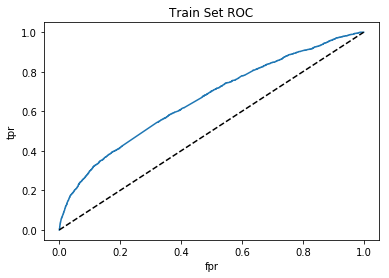

In [48]:
y_pred_prob = clf.predict_proba(X_train_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.plot([0,1],[0,1],'k--')
plt.title('Train Set ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')

In [49]:
auc = me.roc_auc_score(y_train, y_pred_prob)
print 'The train set AUC is', auc

The train set AUC is 0.6592817255339941


In [50]:
ks=max(tpr-fpr)
print 'KS score for train set is', ks

KS score for train set is 0.22300754481059065


Text(0,0.5,'tpr')

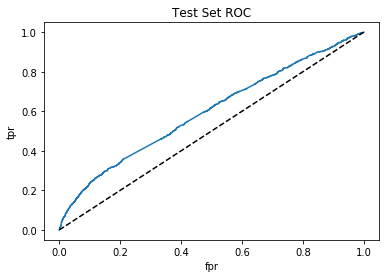

In [51]:
y_pred_proba = clf.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.plot([0,1],[0,1],'k--')
plt.title('Test Set ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')

In [52]:
auc1 = me.roc_auc_score(y_test, y_pred_proba)
print 'The test set AUC is', auc1

The test set AUC is 0.596894907846617


In [53]:
ks=max(tpr-fpr)
print 'KS score for test set is', ks

KS score for test set is 0.14886632440293668


Lift Chart

In [54]:
train_sorted = train.sort_values(by = 'proba', ascending = False) # sort by score

In [55]:
train_sorted.shape[0]/10

1715

In [56]:
a = train_sorted.shape[0]/10
number_list = [0,a+1,2*a+1, 3*a+1, 4*a+1, 5*a+1, 6*a+1, 7*a+1, 8*a+1]
mean = [train_sorted.iloc[i:i+a,:].y.mean() for i in number_list] #average recovery rate
b = train_sorted.iloc[9*a+1:,:].y.mean()
mean.append(b)
mean

[0.31486880466472306,
 0.1673469387755102,
 0.12653061224489795,
 0.1259475218658892,
 0.10845481049562682,
 0.11603498542274053,
 0.10612244897959183,
 0.08396501457725948,
 0.0629737609329446,
 0.07275902211874273]

Text(0.5,0,'Ranked Subset')

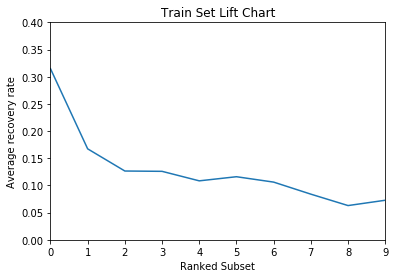

In [88]:
plt.plot(mean)
plt.axis([0,9,0,0.4])
plt.title('Train Set Lift Chart')
plt.ylabel('Average recovery rate')
plt.xlabel('Ranked Subset')

In [58]:
test_sorted = test.sort_values(by = 'proba', ascending = False) # sort by score

In [59]:
c = test_sorted.shape[0]/10
number_list = [0,c+1,2*c+1, 3*c+1, 4*c+1, 5*c+1, 6*c+1, 7*c+1, 8*c+1]
mean_test = [test_sorted.iloc[i:i+c,:].y.mean() for i in number_list] #average recovery rate
b = test_sorted.iloc[9*c+1:,:].y.mean()
mean_test.append(b)
mean_test

[0.254739336492891,
 0.16113744075829384,
 0.11255924170616113,
 0.11966824644549763,
 0.12677725118483413,
 0.11966824644549763,
 0.0971563981042654,
 0.0947867298578199,
 0.10071090047393365,
 0.09624413145539906]

Text(0.5,0,'Ranked Subset')

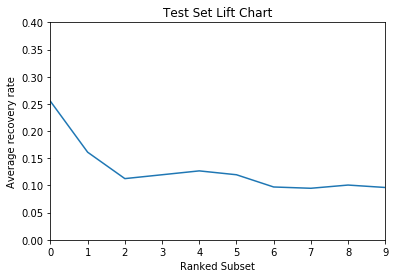

In [89]:
plt.plot(mean_test)
plt.axis([0,9,0,0.4])
plt.title('Test Set Lift Chart')
plt.ylabel('Average recovery rate')
plt.xlabel('Ranked Subset')

Dollar Recovery Percentage

In [61]:
a = train_sorted.shape[0]/10
number_list = [0,a+1,2*a+1, 3*a+1, 4*a+1, 5*a+1, 6*a+1, 7*a+1, 8*a+1]
sum_train = [train_sorted.iloc[i:i+a,:].six_month_repayment.sum() for i in number_list] #average recovery rate
b = train_sorted.iloc[9*a+1:,:].six_month_repayment.sum()
sum_train.append(b)
sum_train

sum_prin_train = [train_sorted.iloc[i:i+a,:].charge_off_gross_bal.sum() for i in number_list] #average recovery rate
b = train_sorted.iloc[9*a+1:,:].charge_off_gross_bal.sum()
sum_prin_train.append(b)
sum_prin_train

dollar_percent = [x/y for x, y in zip(sum_train,sum_prin_train)]
dollar_percent

[0.05914612919205909,
 0.029141956611973788,
 0.02129956236893246,
 0.024968521292322077,
 0.023974973285401543,
 0.025507032534597723,
 0.017950838258267328,
 0.012851145650392911,
 0.010684428082859848,
 0.015570194233359851]

Text(0.5,0,'Ranked Subset')

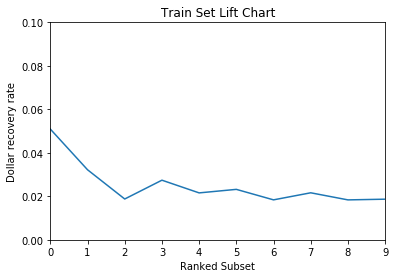

In [84]:
plt.plot(dollar_percent)
plt.axis([0,9,0,0.1])
plt.title('Train Set Lift Chart')
plt.ylabel('Dollar recovery rate')
plt.xlabel('Ranked Subset')

In [63]:
c = test_sorted.shape[0]/10
number_list = [0,c+1,2*c+1, 3*c+1, 4*c+1, 5*c+1, 6*c+1, 7*c+1, 8*c+1]
sum_test = [test_sorted.iloc[i:i+c,:].six_month_repayment.sum() for i in number_list] #average recovery rate
b = test_sorted.iloc[9*c+1:,:].six_month_repayment.sum()
sum_test.append(b)

In [64]:
sum_prin_test = [test_sorted.iloc[i:i+c,:].charge_off_gross_bal.sum() for i in number_list] #average recovery rate
b = test_sorted.iloc[9*c+1:,:].charge_off_gross_bal.sum()
sum_prin_test .append(b)

In [65]:
dollar_percent = [x/y for x, y in zip(sum_test,sum_prin_test)]
dollar_percent

[0.050917085446759186,
 0.03221512695564839,
 0.01876373983341676,
 0.027415539461937637,
 0.021573460390273805,
 0.023195069939964872,
 0.018369088131360123,
 0.02161821479870538,
 0.01835496236391431,
 0.018678266589758335]

Text(0.5,0,'Ranked Subset')

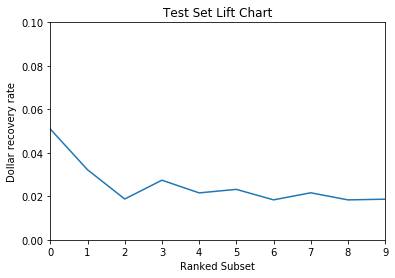

In [83]:
plt.plot(dollar_percent)
plt.axis([0,9,0,0.1])
plt.title('Test Set Lift Chart')
plt.ylabel('Dollar recovery rate')
plt.xlabel('Ranked Subset')

## Append Score

In [141]:
X_all = modifiedRaw['comments']

In [142]:
X_all_counts = cv.transform(X_all)

In [143]:
X_all_tfidf = tfidf_transformer.transform(X_all_counts)

In [144]:
modifiedRaw['score'] = clf.predict_proba(X_all_tfidf)[:,1]

In [146]:
modifiedRaw[modifiedRaw['loan_id'] == 5354612]

,Unnamed: 0,X,loan_id,charge_off_type,charge_off_d,product,charge_off_gross_bal,charge_off_month,grade,term,three_month_repayment,six_month_repayment,nine_month_repayment,comments,numb_of_comments,percent_recovered_three_month,percent_recovered_six_month,percent_recovered_nine_month,score
29072,29073,29073,5354612,Contractual,2016-02-29,Prime,1538.706,2016-02,NaN,NaN,0.0,360.0,615.48,gave him an update on his status and on how to...,11.0,0.0,0.233963,0.399998,0.189653


## Add Behavior Score

In [1]:
bs =pd.read_csv('jzhu_nonDSC_seg_0712_bmerge.csv')
#bs.isnull().sum()
#list(bs.columns)

NameError: name 'pd' is not defined

In [113]:
df = pd.merge(modifiedRaw, bs, on = 'loan_id', how = 'left')
df.shape

(25603, 125)

In [117]:
df.groupby('product_x').loan_id.count()

product_x
Citi CRA                238
Near Prime             3682
Prime                 21561
Prime DTI 35 to 40        1
Small Business           91
Superprime               30
Name: loan_id, dtype: int64

In [118]:
# Export file to use for ensembled model
df.to_csv(r'export_nonDSC_0722.csv', index = None, header = True)

In [120]:
df.shape

(25603, 125)